In [1]:
from matplotlib import pyplot as plt
import cv2, numpy as np, pathlib, os, PIL, PIL.Image, glob
import numpy as np
from skimage import data
from skimage import io, morphology
import tensorflow as tf
import time
from PIL import Image
import math
import timeit
import pywt
from sklearn.metrics import accuracy_score as acc, auc, f1_score
import warnings
from sklearn import metrics

width = 512
height = 512
dim = (width, height)
sharpen = np.array([
    [0, -1, 0],
    [-1, 5, -1],
    [0, -1, 0]
])

strategy = tf.distribute.MirroredStrategy()
print('DEVICES AVAILABLE: {}'.format(strategy.num_replicas_in_sync))

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
DEVICES AVAILABLE: 1


In [38]:
data_dir = pathlib.Path('/kaggle/input/exu-dataset/IMG_EXU_SET').with_suffix('')
data_dir2 = pathlib.Path('/kaggle/input/exu-dataset/IMG_EXU_SET/AbNR').with_suffix('')


NR = data_dir.glob('NR/*.*')
ABNOR = data_dir.glob('ABNOR/*.*')

EX = data_dir2.glob('EX/*.*')
NO_EX =data_dir2.glob('NO_EX/*.*')


data = []
labels = []

data_ex = []
labels_ex = []



for i in NR:   
    
    im1 = cv2.imread(str(i))
    im1 = im1[:,:,1]
    im1 = cv2.resize(im1,dim, interpolation = cv2.INTER_AREA).reshape(dim[0],dim[1])
    data.append(im1)
    labels.append(0)
    
for i in ABNOR:   
    
    im1 = cv2.imread(str(i))
    im1 = im1[:,:,1]
    im1 = cv2.resize(im1,dim, interpolation = cv2.INTER_AREA).reshape(dim[0],dim[1])
    data.append(im1)
    labels.append(1)
    

data = np.array(data)
labels = np.array(labels)

for i in NO_EX:   
    
    im1 = cv2.imread(str(i))
    im1 = im1[:,:,1]
    im1 = cv2.resize(im1,dim, interpolation = cv2.INTER_AREA).reshape(dim[0],dim[1])
    data_ex.append(im1)
    labels_ex.append(0)
    

for i in EX:   
    
    im1 = cv2.imread(str(i))
    im1 = im1[:,:,1]
    im1 = cv2.resize(im1,dim, interpolation = cv2.INTER_AREA).reshape(dim[0],dim[1])
    data_ex.append(im1)
    labels_ex.append(1)
    

data_ex = np.array(data_ex)
labels_ex = np.array(labels_ex)




In [39]:
data_ex.shape

(150, 512, 512)

In [2]:
def encode(labels):

    from sklearn.preprocessing import OneHotEncoder
    onehot_encoder = OneHotEncoder(sparse=False)
    integer_encoded = labels.reshape(len(labels), 1)           #before labels_batch
    label_encoded = onehot_encoder.fit_transform(integer_encoded)
    return label_encoded


In [41]:
from sklearn.model_selection import train_test_split
X_train, X_test, ytrain, ytest = train_test_split(data, encode(labels), test_size=0.15,
                                                random_state=42)


X_train_ex, X_test_ex, ytrain_ex, ytest_ex = train_test_split(data_ex, encode(labels_ex), test_size=0.15,
                                                random_state=42)


In [3]:
import tensorflow as tf

# with strategy.scope():

def get_model_1(width, height):

    inputs = tf.keras.Input((width, height, 1))
    conv1 = tf.keras.layers.Conv2D(filters=16, kernel_size=5, strides=1)(inputs)
    BN1 = tf.keras.layers.BatchNormalization()(conv1)
    relu1 = tf.keras.layers.Activation(activation='relu')(BN1)

    conv2 = tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=2,padding='same')(relu1)
    BN2 = tf.keras.layers.BatchNormalization()(conv2)
    relu2 = tf.keras.layers.Activation(activation='relu')(BN2)

    conv3 = tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=1,padding='same')(relu2)
    BN3 = tf.keras.layers.BatchNormalization()(conv3)
    relu3 = tf.keras.layers.Activation(activation='relu')(BN3)

    skipconv = tf.keras.layers.Conv2D(filters=32, kernel_size=1, strides=2)(relu1)

    Add = tf.keras.layers.Add()([skipconv,relu3])
    AvgPool = tf.keras.layers.AveragePooling2D(pool_size=(2,2), strides=2)(Add)
    FC = tf.keras.layers.Flatten()(AvgPool)

    output = tf.keras.layers.Dense(2,activation='softmax')(FC)



    model = tf.keras.Model(inputs, output,name='BASE_MODEL')

    return model





In [42]:

# Build model.
width = data[0][0].shape[0]
height = data[0][1].shape[0]

with strategy.scope():
    model1 = get_model_1(width, height)

model1.summary()


Model: "BASE_MODEL"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_12 (Conv2D)             (None, 508, 508, 16  416         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_9 (BatchNo  (None, 508, 508, 16  64         ['conv2d_12[0][0]']              
 rmalization)                   )                                                        

In [48]:
# model1.load_weights('/kaggle/working/No_Process_model1.h5')

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-4,
    decay_steps=10000,
    decay_rate=0.9)

with strategy.scope():
    model1.compile(
        loss="binary_crossentropy",
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        metrics=['acc',tf.keras.metrics.Precision(),
                          tf.keras.metrics.Recall()],
    )

# Define callbacks.
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    "image_classification.h5", save_best_only=True
)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor="acc", patience=4)


epochs = 10
model1.fit(
    x=X_train,
    y=ytrain,
    validation_split=0.1,
    validation_freq=5,
    epochs=epochs,
    shuffle=True,
    batch_size=32,
    
    # callbacks=[checkpoint_cb, early_stopping_cb],
)

Epoch 1/10
5/5 [==============================] - 9s 163ms/step - loss: 1.9606e-04 - acc: 1.0000 - precision_2: 1.0000 - recall_2: 1.0000
Epoch 2/10
5/5 [==============================] - 1s 146ms/step - loss: 0.0036 - acc: 1.0000 - precision_2: 1.0000 - recall_2: 1.0000
Epoch 3/10
5/5 [==============================] - 1s 155ms/step - loss: 0.0102 - acc: 1.0000 - precision_2: 1.0000 - recall_2: 1.0000
Epoch 4/10
5/5 [==============================] - 1s 166ms/step - loss: 0.0065 - acc: 1.0000 - precision_2: 1.0000 - recall_2: 1.0000
Epoch 5/10
5/5 [==============================] - 2s 336ms/step - loss: 7.4960e-05 - acc: 1.0000 - precision_2: 1.0000 - recall_2: 1.0000 - val_loss: 1.7282 - val_acc: 0.8750 - val_precision_2: 0.8750 - val_recall_2: 0.8750
Epoch 6/10
5/5 [==============================] - 1s 132ms/step - loss: 0.0029 - acc: 1.0000 - precision_2: 1.0000 - recall_2: 1.0000
Epoch 7/10
5/5 [==============================] - 1s 161ms/step - loss: 2.7429e-04 - acc: 1.0000 - pre

In [49]:
# model1.load_weights('/kaggle/working/No_Process_model1.h5')
pred = model1.predict(X_test).round()
print('Model Classification report \n\n {}'.format(metrics.classification_report(ytest,pred)))
print('Model accuracy  {} %'.format(metrics.accuracy_score(ytest,pred)*100))


1/1 [==============================] - 1s 1s/step
Model Classification report 

               precision    recall  f1-score   support

           0       0.92      0.73      0.81        15
           1       0.75      0.92      0.83        13

   micro avg       0.82      0.82      0.82        28
   macro avg       0.83      0.83      0.82        28
weighted avg       0.84      0.82      0.82        28
 samples avg       0.82      0.82      0.82        28

Model accuracy  82.14285714285714 %


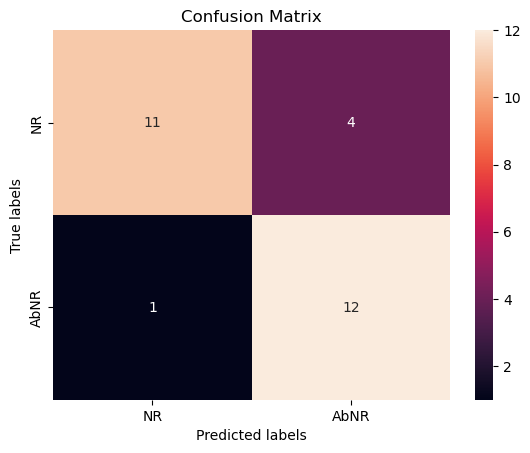

In [50]:
import seaborn as sns
class_names = ['NR','AbNR']  
ax= plt.subplot()
cm = metrics.confusion_matrix(ytest.argmax(axis=1), pred.argmax(axis=1))
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation
# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(class_names); ax.yaxis.set_ticklabels(class_names);


In [51]:
model1.save('No_Process_model1.h5')

In [66]:
import tensorflow as tf

# with strategy.scope():

def get_model_2(width, height):

    inputs = tf.keras.Input((width, height, 1))
    conv1 = tf.keras.layers.Conv2D(filters=16, kernel_size=5, strides=1)(inputs)
    BN1 = tf.keras.layers.BatchNormalization()(conv1)
    relu1 = tf.keras.layers.Activation(activation='relu')(BN1)

    conv2 = tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=2,padding='same')(relu1)
    BN2 = tf.keras.layers.BatchNormalization()(conv2)
    relu2 = tf.keras.layers.Activation(activation='relu')(BN2)

    conv3 = tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=1,padding='same')(relu2)
    BN3 = tf.keras.layers.BatchNormalization()(conv3)
    relu3 = tf.keras.layers.Activation(activation='relu')(BN3)

    skipconv = tf.keras.layers.Conv2D(filters=32, kernel_size=1, strides=2)(relu1)

    Add = tf.keras.layers.Add()([skipconv,relu3])
    AvgPool = tf.keras.layers.AveragePooling2D(pool_size=(2,2), strides=2)(Add)
    FC = tf.keras.layers.Flatten()(AvgPool)

    output = tf.keras.layers.Dense(2,activation='softmax')(FC)



    model = tf.keras.Model(inputs, output,name='BASE_MODEL')

    return model





In [53]:

# Build model.
width = data[0][0].shape[0]
height = data[0][1].shape[0]

with strategy.scope():
    model2 = get_model_2(width, height)

model2.summary()


Model: "BASE_MODEL"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_16 (Conv2D)             (None, 508, 508, 16  416         ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_12 (BatchN  (None, 508, 508, 16  64         ['conv2d_16[0][0]']              
 ormalization)                  )                                                        

In [61]:
# model2.load_weights('/kaggle/working/No_Process_model2.h5')

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-4,
    decay_steps=10000,
    decay_rate=0.9)

with strategy.scope():
    model2.compile(
        loss="binary_crossentropy",
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        metrics=['acc',tf.keras.metrics.Precision(),
                          tf.keras.metrics.Recall()],
    )

# Define callbacks.
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    "image_classification.h5", save_best_only=True
)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor="acc", patience=4)


epochs = 10
model2.fit(
    x=X_train_ex,
    y=ytrain_ex,
    validation_split=0.1,
    validation_freq=5,
    epochs=epochs,
    shuffle=True,
    batch_size=32,
    
    # callbacks=[checkpoint_cb, early_stopping_cb],
)

Epoch 1/10
4/4 [==============================] - 9s 160ms/step - loss: 0.3306 - acc: 0.9561 - precision_6: 0.9561 - recall_6: 0.9561
Epoch 2/10
4/4 [==============================] - 1s 142ms/step - loss: 0.1917 - acc: 0.9561 - precision_6: 0.9561 - recall_6: 0.9561
Epoch 3/10
4/4 [==============================] - 1s 143ms/step - loss: 0.4894 - acc: 0.9123 - precision_6: 0.9123 - recall_6: 0.9123
Epoch 4/10
4/4 [==============================] - 1s 130ms/step - loss: 0.1860 - acc: 0.9649 - precision_6: 0.9649 - recall_6: 0.9649
Epoch 5/10
4/4 [==============================] - 2s 756ms/step - loss: 0.0288 - acc: 0.9912 - precision_6: 0.9912 - recall_6: 0.9912 - val_loss: 2.4379 - val_acc: 0.5385 - val_precision_6: 0.5385 - val_recall_6: 0.5385
Epoch 6/10
4/4 [==============================] - 1s 184ms/step - loss: 0.1816 - acc: 0.9825 - precision_6: 0.9825 - recall_6: 0.9825
Epoch 7/10
4/4 [==============================] - 1s 143ms/step - loss: 0.1452 - acc: 0.9737 - precision_6: 0.

In [62]:
pred2 = model2.predict(X_test_ex).round()
print('Model Classification report \n\n {}'.format(metrics.classification_report(ytest_ex,pred2)))
print('Model accuracy  {} %'.format(metrics.accuracy_score(ytest_ex,pred2)*100))


1/1 [==============================] - 1s 1s/step
Model Classification report 

               precision    recall  f1-score   support

           0       0.64      0.70      0.67        10
           1       0.75      0.69      0.72        13

   micro avg       0.70      0.70      0.70        23
   macro avg       0.69      0.70      0.69        23
weighted avg       0.70      0.70      0.70        23
 samples avg       0.70      0.70      0.70        23

Model accuracy  69.56521739130434 %


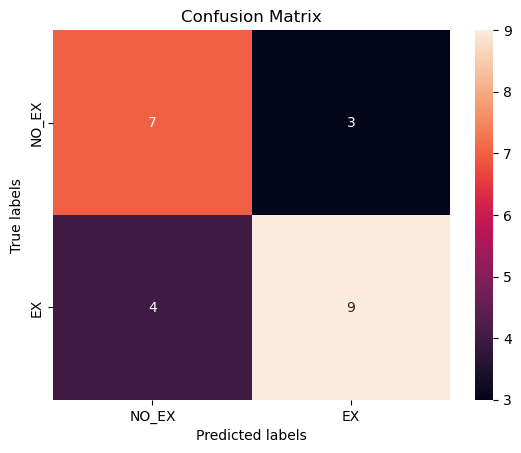

In [63]:
import seaborn as sns
class_names = ['NO_EX','EX']  
ax= plt.subplot()
cm = metrics.confusion_matrix(ytest_ex.argmax(axis=1), pred2.argmax(axis=1))
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation
# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(class_names); ax.yaxis.set_ticklabels(class_names);


In [64]:
model2.save('No_Process_model2.h5')

In [ ]:
data_dir = pathlib.Path('IMG_EXU_SET').with_suffix('')
# data_dir2 = pathlib.Path('IMG_EXU_SET/AbNR').with_suffix('')


NR = data_dir.glob('NR/*.*')
# ABNOR = data_dir.glob('ABNOR/*.*')

EX = data_dir.glob('AbNR/EX/*.*')
NO_EX =data_dir.glob('AbNR/NO_EX/*.*')

data_ex_ = []
data_ = []
labels_ = []
labels_ex_ = []
dim = (512,512)


for i in NR:   
    
    im1 = cv2.imread(str(i))
    im1 = im1[:,:,1]
    im1 = cv2.resize(im1,dim, interpolation = cv2.INTER_AREA).reshape(dim[0],dim[1])
    data_.append(im1)
    labels_.append(0)
    labels_ex_.append(0)
    

for i in EX:   
    
    im1 = cv2.imread(str(i))
    im1 = im1[:,:,1]
    im1 = cv2.resize(im1,dim, interpolation = cv2.INTER_AREA).reshape(dim[0],dim[1])
    data_.append(im1)
#     data_ex.append(im1)
    labels_.append(1) #For abnormal
    labels_ex_.append(1) #For abnormal with Exudate
    
for i in NO_EX:   
    
    im1 = cv2.imread(str(i))
    im1 = im1[:,:,1]
    im1 = cv2.resize(im1,dim, interpolation = cv2.INTER_AREA).reshape(dim[0],dim[1])
    data_.append(im1)
#     data_ex.append(im1)
    labels_.append(2)
    labels_ex_.append(0)
    

# data_ex = np.array(data_ex)
labels_ex_ = encode(np.array(labels_ex_))
data_ = np.array(data_)
labels_ = encode(np.array(labels_))




In [7]:
model1 = get_model_1(512, 512)
model1.load_weights('No_Process_model1.h5')

model2 = get_model_1(512, 512)
model2.load_weights('No_Process_model2.h5')


In [72]:
#60:80 NR
#115:135 EX
#200:220 N
data1 = data_[43:63]
data2 = data_[171:183]
data3 = data_[197:207]
testdata = np.concatenate((data1, data2,data3))

ex1 = labels_ex_[43:63]
ex2 = labels_ex_[171:183]
ex3 = labels_ex_[197:207]
testlabels_ex = np.concatenate((ex1,ex2,ex3))

l1 = labels_[43:63]
l2 = labels_[171:183]
l3 = labels_[197:207]
testlabels = np.concatenate((l1,l2,l3))

testdata.shape,testlabels.shape, testlabels_ex.shape

((42, 512, 512), (42, 2), (42, 2))

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, ytrain, ytest = train_test_split(data_, labels_, test_size=0.15,
                                                random_state=42)


X_train_ex, X_test_ex, ytrain_ex, ytest_ex = train_test_split(data_[79:], labels_ex_[79:], test_size=0.15,
                                                random_state=42)


In [17]:
X_test.shape

(35, 512, 512)

In [18]:
dtest =[X_test[i] for i in range(X_test.shape[0])]
for i in range(X_test_ex.shape[0]):
  dtest.append(X_test_ex[i])

dtest = np.array(dtest)

dytest = [ytest[i] for i in range(ytest.shape[0])]
for i in range(ytest_ex.shape[0]):
  dytest.append(ytest_ex[i])

dytest = np.array(dytest)


dtest.shape,dytest.shape



((58, 512, 512), (58, 2))

In [38]:
Normal = [[1.,0.]]
NotNormal = [[0.,1.]]
Exudate = [[0.,1.]]
NoExudate = [[1.,0.]]

acc1 = []
acc2 = []
accu =[]
P1= []

# data_2.shape,labels_2.shape, labels_ex_2.shape

for i in range(dtest.shape[0]):

    pred1 = model1.predict(dtest[i].reshape(-1,512,512,1)).round()
    
    acc1.append(metrics.accuracy_score(dytest[i].reshape(1,2),pred1))
    
    
    if (pred1 == Normal).all(): 
        accu.append(metrics.accuracy_score(dytest[i].reshape(1,2),pred1) )
        P1.append(pred1)

    if (pred1 != Normal).all():        
        pred2 = model2.predict(dtest[i].reshape(-1,512,512,1)).round()
        P1.append(pred2)
        acc2.append(metrics.accuracy_score(dytest[i].reshape(1,2),pred2))
        
        accu.append(metrics.accuracy_score(dytest[i].reshape(1,2),pred2))
        
        



1/1 [==============================] - 0s 81ms/step


In [55]:
P1[0][0]

0.0

In [56]:
prd=[]
for i in range(len(P1)):
    prd.append([P1[i][0][0],P1[i][0][1]])
    
prd = np.array(prd)

In [26]:
from statistics import mean
print('Model1 acc: ',mean(acc1))
print('Model2 acc: ',mean(acc2))
print('Overall Model acc: ',mean(accu))

Model1 acc:  0.8620689655172413
Model2 acc:  0.7608695652173914
Overall Model acc:  0.7758620689655172


In [63]:

print('Model Classification report \n\n {}'.format(metrics.classification_report(dytest,prd)))
print('Model accuracy  {} %'.format(metrics.accuracy_score(dytest,prd)*100))


Model Classification report 

               precision    recall  f1-score   support

           0       0.55      1.00      0.71        16
           1       1.00      0.69      0.82        42

   micro avg       0.78      0.78      0.78        58
   macro avg       0.78      0.85      0.76        58
weighted avg       0.88      0.78      0.79        58
 samples avg       0.78      0.78      0.78        58

Model accuracy  77.58620689655173 %


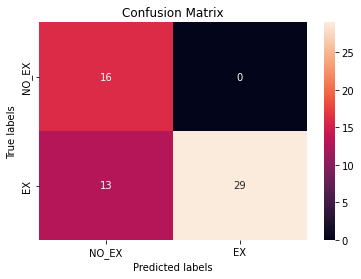

In [61]:
import seaborn as sns
class_names = ['NR','EX','NO EX']  
ax= plt.subplot()
cm = metrics.confusion_matrix(dytest.argmax(axis=1), prd.argmax(axis=1))
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation
# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(class_names); ax.yaxis.set_ticklabels(class_names);


#### DATASET 2

In [75]:
data_dir = pathlib.Path('/kaggle/input/img-ex2-dataset').with_suffix('')
# data_dir2 = pathlib.Path('IMG_EXU_SET/AbNR').with_suffix('')


NR = data_dir.glob('NR/*.*')
# ABNOR = data_dir.glob('ABNOR/*.*')

EX = data_dir.glob('EX/*.*')
NO_EX =data_dir.glob('NO_EX/*.*')

data_ex_2 = []
data_2 = []
labels_2 = []
labels_ex_2 = []



for i in NR:   
    
    im1 = cv2.imread(str(i))
    im1 = im1[:,:,1]
    im1 = cv2.resize(im1,dim, interpolation = cv2.INTER_AREA).reshape(dim[0],dim[1])
    data_2.append(im1)
    labels_2.append(0)
    labels_ex_2.append(0)
    

for i in EX:   
    
    im1 = cv2.imread(str(i))
    im1 = im1[:,:,1]
    im1 = cv2.resize(im1,dim, interpolation = cv2.INTER_AREA).reshape(dim[0],dim[1])
    data_2.append(im1)
#     data_ex.append(im1)
    labels_2.append(1) #For abnormal
    labels_ex_2.append(1) #For abnormal with Exudate
    
for i in NO_EX:   
    
    im1 = cv2.imread(str(i))
    im1 = im1[:,:,1]
    im1 = cv2.resize(im1,dim, interpolation = cv2.INTER_AREA).reshape(dim[0],dim[1])
    data_2.append(im1)
#     data_ex.append(im1)
    labels_2.append(1)
    labels_ex_2.append(0)
    

# data_ex = np.array(data_ex)
labels_ex_2 = encode(np.array(labels_ex_2))
data_2 = np.array(data_2)
labels_2 = encode(np.array(labels_2))




In [85]:
Normal = [[1.,0.]]
NotNormal = [[0.,1.]]
Exudate = [[0.,1.]]
NoExudate = [[1.,0.]]

acc1 = []
acc2 = []

for i in range(data_2.shape[0]):

    pred1 = model1.predict(data_2[i].reshape(1,512,512)).round()
    acc1.append(metrics.accuracy_score(labels_2[i].reshape(1,2),pred1))

    if (pred1 != Normal).all():        
        pred2 = model2.predict(data_2[i].reshape(1,512,512)).round()
        acc2.append(metrics.accuracy_score(labels_ex_2[i].reshape(1,2),pred2))
        
        



1/1 [==============================] - 0s 128ms/step


In [86]:
from statistics import mean
print('Model1 acc: ',mean(acc1))
print('Model2 acc: ',mean(acc2))
m = (mean(acc2) + mean(acc1))/2
print('Overall Model acc: ',m)

Model1 acc:  0.7333333333333333
Model2 acc:  0.5205479452054794
Overall Model acc:  0.6269406392694064
